In [1]:
from __future__ import print_function

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize']=(10.0,8.0)
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gray'

In [2]:
# Load the raw CIFAR-10 data
cifar10_dir='cs231n/datasets/cifar-10-batches-py'

#Cleaning up variable
try:
    del X_train,y_train
    del X_test,y_test
    print('Clear previously loaded data.')
except:
    pass

X_train,y_train,X_test,y_test=load_CIFAR10(cifar10_dir)
#print out the size of the training and test data

print('Training data shape:',X_train.shape)
print('Training labels shape:',y_train.shape)
print('Test data shape:',X_test.shape)
print('Test labels shape:',y_test.shape)

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000,)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


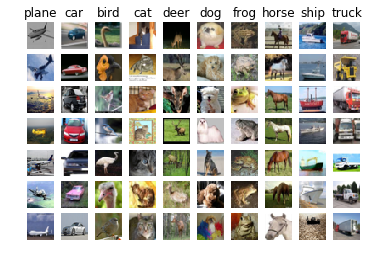

In [3]:
#Visualize
#We show a few examples of training images from each class
classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']
num_classes=len(classes)
samples_per_class=7
for y,cls in enumerate(classes):
    idxs=np.flatnonzero(y_train == y)
    #通过给定的一维数组数据产生随机采样，在第一个参数的范围下随机采样，第二个参数
    #决定了输出的shape，而replace=False则表示采样的数字不重复
    idxs=np.random.choice(idxs,samples_per_class,replace=False)
    for i,idx in enumerate(idxs):
        plt_idx=i*num_classes +y+1
        plt.subplot(samples_per_class,num_classes,plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i==0:
            plt.title(cls)
plt.show()

In [4]:
#Subsample the data for more efficient code excution in this exercise
num_training=5000
mask=list(range(num_training))
X_train=X_train[mask]
y_train=y_train[mask]

num_test=500
mask=list(range(num_test))
X_test=X_test[mask]
y_test=y_test[mask]
##有疑问，下一模块存在的必要性

In [5]:
#reshape the image data into rows
X_train=np.reshape(X_train,(X_train.shape[0],-1))
X_test=np.reshape(X_test,(X_test.shape[0],-1))
print(X_train.shape,X_test.shape)

(5000, 3072) (500, 3072)


In [6]:
from cs231n.classifiers import KNearestNeighbor

classifier=KNearestNeighbor()
classifier.train(X_train,y_train)

In [7]:
#compute_distances_two_loops
dists=classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


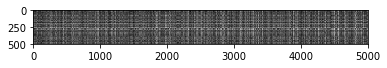

In [8]:
#visualise
plt.imshow(dists,interpolation='none')
plt.show()

In [9]:
#predict
y_test_pred=classifier.predict_labels(dists,k=1)

#compute the fraction of correctly predicted example
num_correct = np.sum(y_test_pred==y_test)
accuracy=float(num_correct)/ num_test
print('Got %d / %d correct=>accuracy: %f' % (num_correct,num_test,accuracy))

Got 137 / 500 correct=>accuracy: 0.274000


In [11]:
#predict
y_test_pred=classifier.predict_labels(dists,k=5)

#compute the fraction of correctly predicted example
num_correct = np.sum(y_test_pred==y_test)
accuracy=float(num_correct)/ num_test
print('Got %d / %d correct=>accuracy: %f' % (num_correct,num_test,accuracy))

Got 139 / 500 correct=>accuracy: 0.278000


In [14]:
dists_one=classifier.compute_distances_one_loop(X_test)

#x_norm = np.linalg.norm(x,ord(范数类型）= None,axis=None,keepdims=False)
difference=np.linalg.norm(dists-dists_one,ord='fro')
print('Difference was: %f' % (difference,))
if difference < 0.001:
    print('Good! The distance matrices are the same.')
else:
    print('Uh-oh! The distance matrices is different.')

Difference was: 0.000000
Good! The distance matrices are the same.


In [17]:
def time_function(f,*args):
    import time
    #返回当前的时间戳，19700纪元后经过的浮点秒数
    tic=time.time()
    #怎么理解这个语句
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time=time_function(classifier.compute_distances_two_loops,X_test)
print('Two loop version toook %f seconds.' % two_loop_time)

one_loop_time=time_function(classifier.compute_distances_one_loop,X_test)
print('One loop version took %f seconds.' % one_loop_time)

no_loop_time=time_function(classifier.compute_distances_no_loops,X_test)
print('No loopp version took %f seconds.' % no_loop_time)

Two loop version toook 38.457271 seconds.
One loop version took 108.299879 seconds.
No loopp version took 0.433751 seconds.


In [35]:
#在上述问题中，我们通过设定 K=1，K=5，发现 K=5 的时候预测的准确率更大一些，
#那我们如何找到一个最优的超参数 K 呢，这就体现交叉验证集的作用了。
num_folds=5
k_choices = [1,3,5,8,10,12,15,20,50,100]

X_train_folds=[]
y_train_folds=[]

#把下标分成五个部分
indices = np.array_split(np.arange(num_training),indices_or_sections=num_folds)

for i in indices:
    X_train_folds.append(X_train[i])
    y_train_folds.append(y_train[i])

k_to_accuracies={}

#进行交叉验证：
for k in k_choices:
    acc=[]
    for i in range(num_folds):
        x=X_train_folds[0:i] + X_train_folds[i+1:]
        x=np.concatenate(x,axis=0)
        y=y_train_folds[0:i] + y_train_folds[i+1:]
        y=np.concatenate(y,axis=0)
        test_x=X_train_folds[i]
        test_y=y_train_folds[i]
        
        classifier=KNearestNeighbor()
        classifier.train(x,y)
        dist=classifier.compute_distances_no_loops(test_x)
        y_pred=classifier.predict_labels(dist,k)
        accuracy=np.mean(y_pred==test_y)
        acc.append(accuracy)
    k_to_accuracies[k]=acc

for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k=%d,accuracy=%f.'% (k,accuracy))
        
print(k_to_accuracies)

k=1,accuracy=0.263000.
k=1,accuracy=0.257000.
k=1,accuracy=0.264000.
k=1,accuracy=0.278000.
k=1,accuracy=0.266000.
k=3,accuracy=0.239000.
k=3,accuracy=0.249000.
k=3,accuracy=0.240000.
k=3,accuracy=0.266000.
k=3,accuracy=0.254000.
k=5,accuracy=0.248000.
k=5,accuracy=0.266000.
k=5,accuracy=0.280000.
k=5,accuracy=0.292000.
k=5,accuracy=0.280000.
k=8,accuracy=0.262000.
k=8,accuracy=0.282000.
k=8,accuracy=0.273000.
k=8,accuracy=0.290000.
k=8,accuracy=0.273000.
k=10,accuracy=0.265000.
k=10,accuracy=0.296000.
k=10,accuracy=0.276000.
k=10,accuracy=0.284000.
k=10,accuracy=0.280000.
k=12,accuracy=0.260000.
k=12,accuracy=0.295000.
k=12,accuracy=0.279000.
k=12,accuracy=0.283000.
k=12,accuracy=0.280000.
k=15,accuracy=0.252000.
k=15,accuracy=0.289000.
k=15,accuracy=0.278000.
k=15,accuracy=0.282000.
k=15,accuracy=0.274000.
k=20,accuracy=0.270000.
k=20,accuracy=0.279000.
k=20,accuracy=0.279000.
k=20,accuracy=0.282000.
k=20,accuracy=0.285000.
k=50,accuracy=0.271000.
k=50,accuracy=0.288000.
k=50,accurac

使用交叉验证（cross-validation）去获取knn中的超参数K 的最佳值，其基本思想是：将训练集划分为num_folds个循环块，循环的把其中的一个块作为验证集，计算不同K值下所有遍历的验证集上的准确率（num_folds个结果）的平均值作为该K值在训练集上的准确率，然后选择准确率最高的K值
然后再使用一个循环（num_folds）,每一次循环里选择其中一个块作为验证集，然后把剩下的作为训练集，调用train函数训练，然后使用predict得到验证集的预测标签，判断预测标签和实际标签对应的正确率，作为该K值下该块验证集对应的准确率

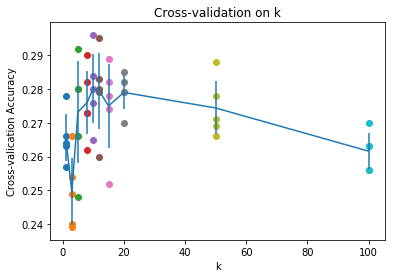

In [39]:
#plot allowing accuracy 画散点
for k in k_choices:
    #accuracies有五个元素，即同一 K 值的不同交叉集验证的准确率
    accurcies=k_to_accuracies[k]
    plt.scatter([k] * len(accurcies),accurcies)    
#plot line 差棒图
accurcies_mean=np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accurcies_std=np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices,accurcies_mean,yerr=accurcies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-valication Accuracy')
plt.show()

In [40]:
#choose the best value for K
best_k=10

classifier=KNearestNeighbor();
classifier.train(X_train,y_train)
y_test_pred=classifier.predict(X_test,k=best_k)

num_correct=np.sum(y_test_pred==y_test)
accuracy=float(num_correct) /num_test
print('Got %d / %d correct =>accuracy : % f' % (num_classes,num_test,accuracy))

Got 10 / 500 correct =>accuracy :  0.282000
